In [53]:
import pandas as pd
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

from data_import import *
from modeling_prep import *

##### Data Import

In [2]:
oregon_data_dict = oregon_import(float_32=True)

file import: 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]


In [39]:
wa_dict = single_oregon_county(oregon_data_dict, 41067)

processing dfs: 100%|██████████| 3/3 [00:00<00:00, 12.22it/s]


##### Examining data suitability for VARMAX

Verifying stationarity of data

In [8]:
#looking at one county in particular

wa_df = oregon_data_dict['train_timeseries'].copy()
wa_df = wa_df[wa_df['fips']==41067]
wa_df.drop(columns=['fips'],inplace=True)
wa_df = wa_df.iloc[4:,:]
wa_df = wa_df.iloc[:-4,:]
wa_df['date'] = wa_df['date'].map(pd.Timestamp.timestamp)
wa_df.reset_index(inplace=True,drop=True)
wa_county_score_list = wa_df['score'].dropna().copy()


result = adfuller(wa_county_score_list)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -5.508469601022172
p-value: 1.9969356496943797e-06


In [7]:
oregon_df = oregon_data_dict['train_timeseries'].copy()
oregon_score_list = oregon_df['score'].dropna().copy()

result = adfuller(oregon_score_list)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -15.628872219809024
p-value: 1.695245873408861e-28


##### VARMAX

In [55]:
train_copy = oregon_data_dict['train_timeseries'].copy()
train_copy.dropna(subset=['score'], how='all', inplace=True)

In [56]:
train_data = pd.read_csv('.\processed_data\oregon_train_timeseries.csv',header=0, index_col=1)

split_data_dict = train_test_split_default(train_data)

In [57]:
train_df = train_data.copy()
train_df.index = pd.DatetimeIndex(train_df.index).to_period('M')

In [74]:
train_data = pd.read_csv('.\processed_data\oregon_train_timeseries.csv',header=0, index_col=1)
train_data.index = pd.DatetimeIndex(train_data.index).to_period('M')
train_data = train_data[train_data['fips']==41067]
train_data.drop(columns=['fips'], inplace=True)
train_data.dropna(subset=['score'], how='all', inplace=True)

In [72]:
len(train_data.iloc[:,train_data.columns != 'split'].columns)

19

In [22]:
train_data['score'].values.reshape(-1,1)

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [75]:
endog = train_data.iloc[:,train_data.columns != 'split'].copy()
mod = sm.tsa.VARMAX(endog = endog, order=(2,0), trend='n', exog=train_data['score'].values.reshape(-1,1))
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

LinAlgError: 2-th leading minor of the array is not positive definite

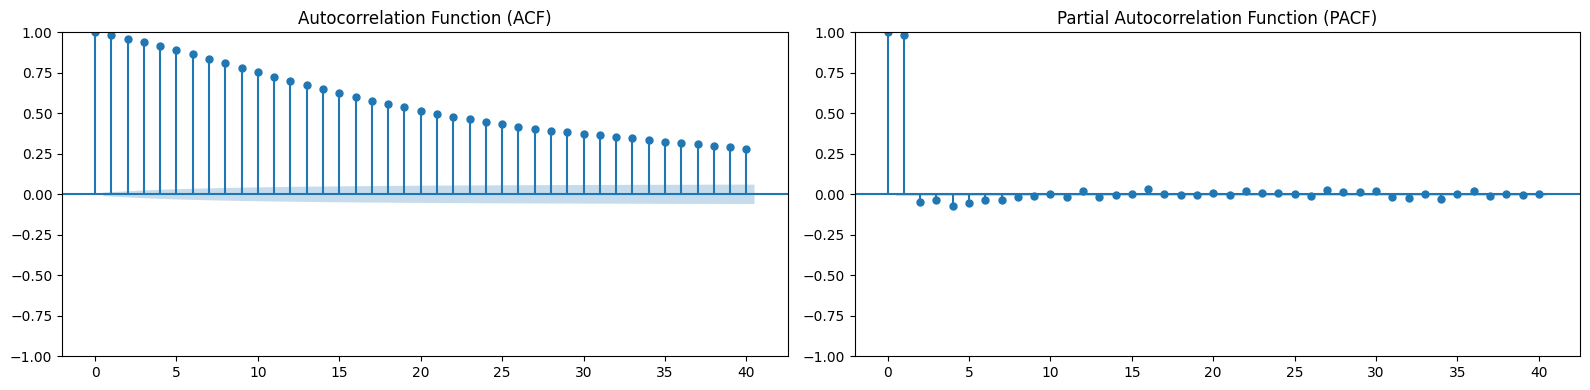

In [ ]:
score = train_data['score'].values.reshape(-1,1)

# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(score, lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(score, lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [31]:
train_df = train_data.copy()
train_df.index = pd.DatetimeIndex(train_df.index).to_period('M')

##### Divider

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		y_hat = model_fit.forecast()[0]
		predictions.append(y_hat)
		history.append(test[t])
	# calculate out of sample error
	rmse = np.sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	# dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				# try:
				rmse = evaluate_arima_model(dataset, order)
				if rmse < best_score:
					best_score, best_cfg = rmse, order
				print('ARIMA%s RMSE=%.3f' % (order,rmse))
				# except:
					# continue
	print('Best ARIMA %s RMSE = %.3f' % (best_cfg, best_score))


# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train_data.values, p_values, d_values, q_values)

##### Modeling

In [ ]:
train_copy = oregon_data_dict['train_timeseries'].copy()
train_copy.dropna(subset=['score'], how='all', inplace=True)

##### Grid Search of ARIMA order values

In [3]:
train_data = pd.read_csv('.\processed_data\oregon_train_timeseries.csv',header=0, index_col=1)

split_data_dict = train_test_split_default(train_data)

In [59]:
grouped_train_data = pd.read_csv('.\processed_data\oregon_train_timeseries.csv',header=0, index_col=1)

split_county_data = county_grouped_shufflesplit(grouped_train_data)

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		y_hat = model_fit.forecast()[0]
		predictions.append(y_hat)
		history.append(test[t])
	# calculate out of sample error
	rmse = np.sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	# dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				# try:
				rmse = evaluate_arima_model(dataset, order)
				if rmse < best_score:
					best_score, best_cfg = rmse, order
				print('ARIMA%s RMSE=%.3f' % (order,rmse))
				# except:
					# continue
	print('Best ARIMA %s RMSE = %.3f' % (best_cfg, best_score))


# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train_data.values, p_values, d_values, q_values)

AttributeError: 'list' object has no attribute 'score'